<a href="https://colab.research.google.com/github/abaskon/Thesis/blob/main/GPR_DBI_VAR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Import Libraries

In [141]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



#####Read data and standardise them

In [143]:
dbi1 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI1985-2004.csv")
dbi2 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI2004-today.csv")

dbi1['Price'] = dbi1['Price'].str.replace(',', '').astype(float)
dbi2['Price'] = dbi2['Price'].str.replace(',', '').astype(float)

In [144]:
dbi1['Date'] = pd.to_datetime(dbi1['Date'], format='%m/%d/%Y')
dbi2['Date'] = pd.to_datetime(dbi2['Date'], format='%m/%d/%Y')

In [145]:
dbi1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2004-11-22,5442.0,"5,442.00","5,442.00","5,442.00",NaN,0.91%
1,2004-11-19,5393.0,"5,393.00","5,393.00","5,393.00",NaN,1.09%
2,2004-11-18,5335.0,"5,335.00","5,335.00","5,335.00",NaN,1.35%
3,2004-11-17,5264.0,"5,264.00","5,264.00","5,264.00",NaN,1.41%
4,2004-11-16,5191.0,"5,191.00","5,191.00","5,191.00",NaN,0.76%


In [146]:
# concatenate the two tables based on the 'date' column
DBI = pd.concat([dbi1, dbi2]).drop_duplicates(subset='Date')

DBI = DBI.sort_values(by='Date', ascending=True)
DBI = DBI.reset_index(drop=True)

In [147]:
DBI

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%
3,1985-01-10,979.5,979.50,979.50,979.50,NaN,-1.51%
4,1985-01-11,980.5,980.50,980.50,980.50,NaN,0.10%
...,...,...,...,...,...,...,...
9595,2023-04-28,1576.0,"1,576.00","1,576.00","1,576.00",NaN,-0.32%
9596,2023-05-02,1552.0,"1,552.00","1,552.00","1,552.00",NaN,-1.52%
9597,2023-05-03,1558.0,"1,558.00","1,558.00","1,558.00",NaN,0.39%
9598,2023-05-04,1545.0,"1,545.00","1,545.00","1,545.00",NaN,-0.83%


In [148]:
GPR = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_daily_recent.csv")
GPRE = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_export.csv")
GPR['GPRD'] = GPR['GPRD'].str.replace(',', '').astype(float)


In [149]:
GPR

,DAY,N10D,GPRD,GPRD_ACT,GPRD_THREAT,date,GPRD_MA30,GPRD_MA7,event,var_name,var_label
0,19850101,216,230.04,275.20,153.03,01-01-1985,230.04,230.04,NaN,DAY,DAY
1,19850102,315,115.68,146.77,87.44,02-01-1985,172.86,172.86,NaN,N10D,"Number of articles (10 recent newspapers, 1985-)"
2,19850103,374,97.43,158.94,29.46,03-01-1985,147.71,147.71,NaN,GPRD,Daily GPR (Index: 1985:2019=100)
3,19850104,421,157.37,156.88,157.03,04-01-1985,150.13,150.13,NaN,GPRD_ACT,Daily GPR Acts (Index: 1985:2019=100)
4,19850105,285,81.36,92.70,77.32,05-01-1985,136.37,136.37,NaN,GPRD_THREAT,Daily GPR Threats (Index: 1985:2019=100)
...,...,...,...,...,...,...,...,...,...,...,...
13988,20230420,470,98.67,126.47,70.33,20-04-2023,93.04,98.11,NaN,NaN,NaN
13989,20230421,453,117.00,102.06,121.61,21-04-2023,92.90,98.72,NaN,NaN,NaN
13990,20230422,522,63.46,101.22,31.66,22-04-2023,91.56,95.33,NaN,NaN,NaN
13991,20230423,355,55.99,93.02,31.04,23-04-2023,90.75,97.36,NaN,NaN,NaN


In [150]:
GPR['date'] = pd.to_datetime(GPR['date'], format='%d-%m-%Y')
GPR = GPR.rename(columns={'date': 'Date'})

In [151]:
GPR = GPR[['Date', 'GPRD', 'event']]

In [152]:
GPR.head(4)

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN
3,1985-01-04,157.37,NaN


In [153]:
GPRE['month'] = pd.to_datetime(GPRE['month'], format='%d-%m-%Y')
GPRE = GPRE.rename(columns={'month': 'Date'})

In [154]:
GPRE.head(6)

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
0,1900-01-01,NaN,NaN,NaN,87.93,64.72,110.45,NaN,NaN,3.17,...,0.08,0.00,0.04,0.00,0.0,2.72,0.05,1.15,month,Date (year/month)
1,1900-02-01,NaN,NaN,NaN,86.57,71.94,96.25,NaN,NaN,3.12,...,0.08,0.00,0.13,0.00,0.0,2.73,0.03,1.14,GPR,Recent GPR (Index: 1985:2019=100)
2,1900-03-01,NaN,NaN,NaN,72.14,57.48,84.50,NaN,NaN,2.60,...,0.12,0.00,0.18,0.00,0.0,2.15,0.03,0.86,GPRT,Recent GPR Threats (Index: 1985:2019=100)
3,1900-04-01,NaN,NaN,NaN,54.42,37.33,65.86,NaN,NaN,1.96,...,0.04,0.00,0.07,0.00,0.0,1.78,0.00,0.64,GPRA,Recent GPR Acts (Index: 1985:2019=100)
4,1900-05-01,NaN,NaN,NaN,64.41,48.20,74.37,NaN,NaN,2.32,...,0.16,0.00,0.08,0.00,0.0,1.97,0.01,0.79,GPRH,Historical GPR (Index: 1900:2019=100)
5,1900-06-01,NaN,NaN,NaN,83.61,70.01,93.98,NaN,NaN,3.02,...,0.08,0.01,0.11,0.03,0.0,2.73,0.03,0.67,GPRHT,Historical GPR Threats (Index: 1900:2019=100)


In [155]:
GPRE[GPRE["Date"] == "1985-02-01"]

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
1021,1985-02-01,117.1,126.44,96.6,99.55,127.21,75.1,3.51,10819.0,3.59,...,0.2,0.04,0.03,0.0,0.01,3.34,0.07,0.11,NaN,NaN


In [156]:
GPR[GPR["Date"] == "1985-02-01"]

,Date,GPRD,event
31,1985-02-01,106.61,NaN


In [157]:
GPRE = GPRE[['Date', 'GPR','GPRC_ARG', 'GPRC_AUS', 'GPRC_BEL', 'GPRC_BRA', 'GPRC_CAN', 'GPRC_CHE', 'GPRC_CHL', 'GPRC_CHN', 'GPRC_COL', 'GPRC_DEU', 'GPRC_DNK', 'GPRC_EGY', 'GPRC_ESP', 'GPRC_FIN', 'GPRC_FRA', 'GPRC_GBR', 'GPRC_HKG', 'GPRC_HUN', 'GPRC_IDN', 'GPRC_IND', 'GPRC_ISR', 'GPRC_ITA', 'GPRC_JPN', 'GPRC_KOR', 'GPRC_MEX', 'GPRC_MYS', 'GPRC_NLD', 'GPRC_NOR', 'GPRC_PER', 'GPRC_PHL', 'GPRC_POL', 'GPRC_PRT', 'GPRC_RUS', 'GPRC_SAU', 'GPRC_SWE', 'GPRC_THA', 'GPRC_TUN', 'GPRC_TUR', 'GPRC_TWN', 'GPRC_UKR', 'GPRC_USA', 'GPRC_VEN', 'GPRC_ZAF']]

In [158]:
GPRE = GPRE[GPRE['Date'] >= '1985-01-01']

In [159]:
GPRE

,Date,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
1020,1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1021,1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1022,1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1023,1985-04-01,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1024,1985-05-01,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,2022-11-01,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
1475,2022-12-01,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
1476,2023-01-01,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04
1477,2023-02-01,127.34,0.01,0.16,0.34,0.06,0.42,0.05,0.04,1.58,...,0.15,0.15,0.02,0.01,0.51,0.37,2.12,3.15,0.02,0.10


#####Visualisations

In [160]:
def plotgraph(df, x, y):
    df[y] = pd.to_numeric(df[y])
    df.plot(x=x, y=y, figsize=(20, 4))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('USD per Metric Tonne')
    plt.show()


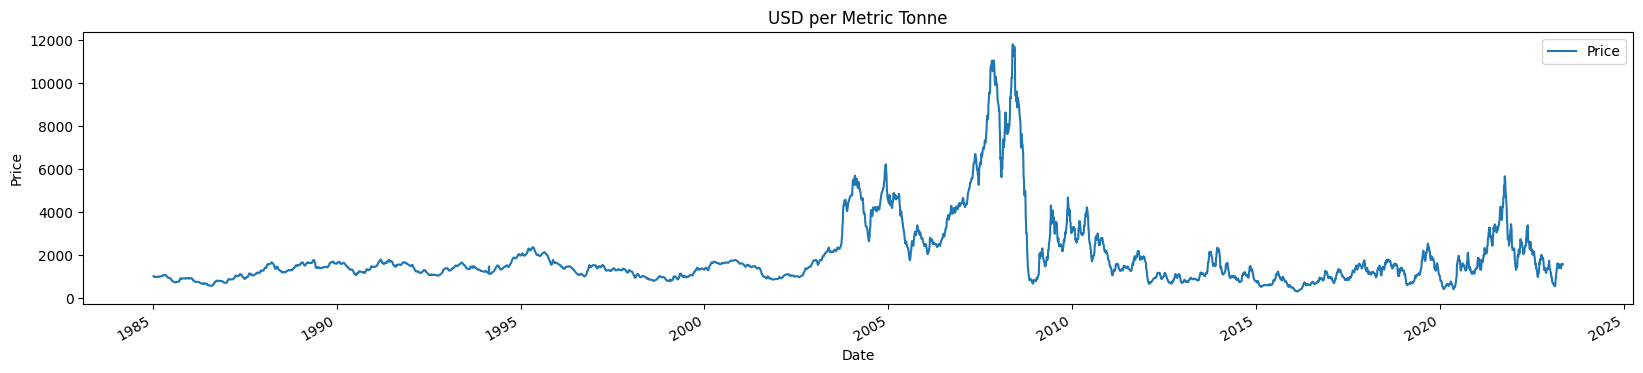

In [161]:
plotgraph(DBI,'Date','Price')

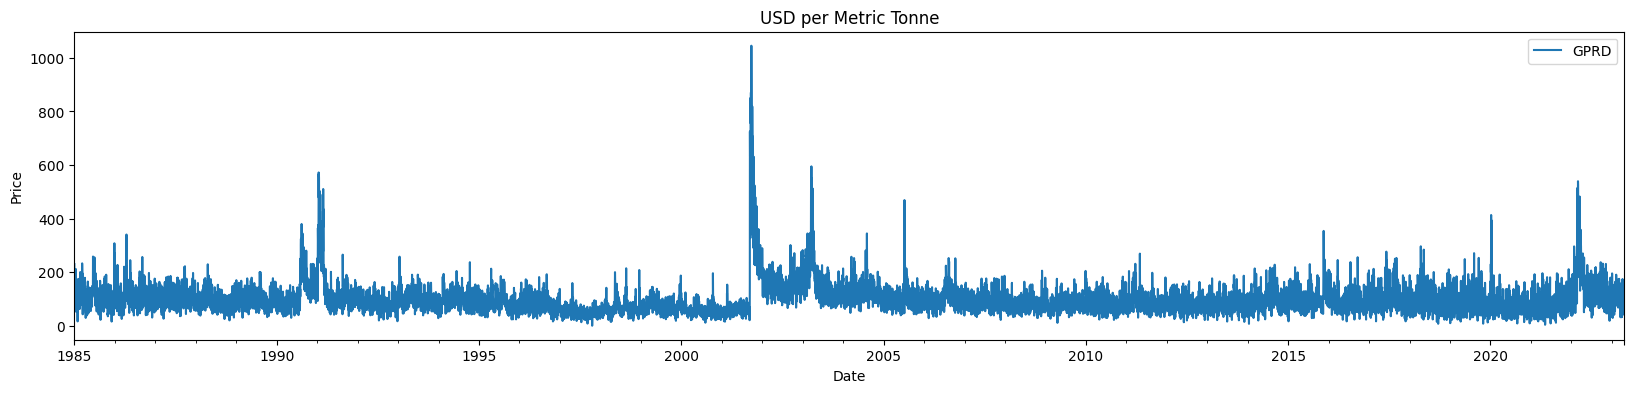

In [162]:
plotgraph(GPR,'Date','GPRD')

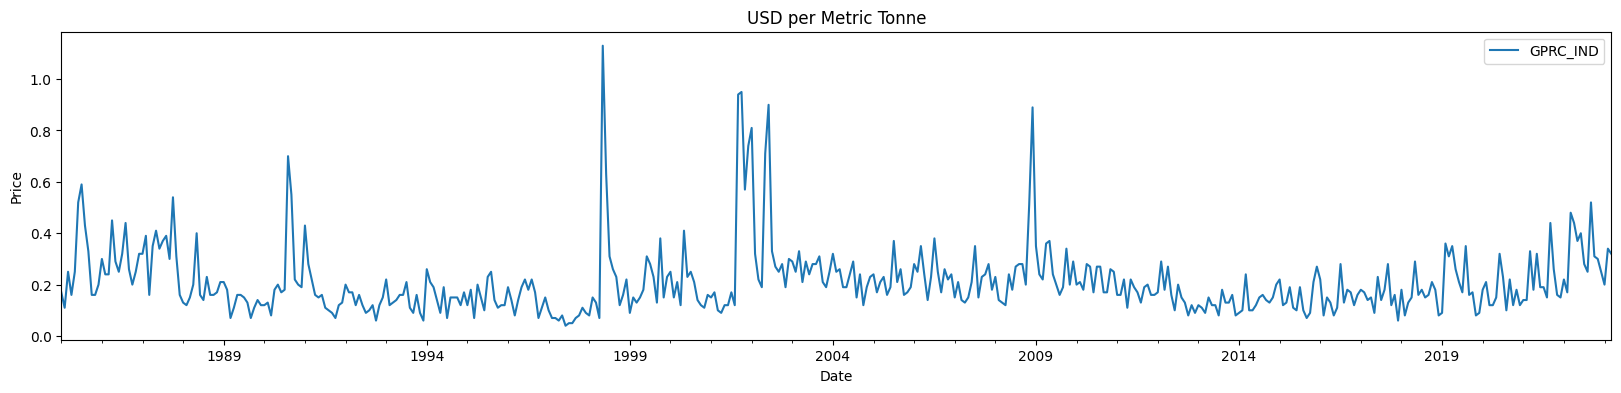

In [163]:
plotgraph(GPRE,'Date','GPRC_IND')

In [164]:
# Plotly line plot
fig = go.Figure(data=[go.Scatter(x=DBI['Date'], y=DBI['Price'])])
fig.show()


#####Others

In [165]:
DBI.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%


In [166]:
DBI = DBI[['Date','Price']]


In [167]:
DBI.set_index('Date', inplace=True)

In [168]:

# Resample the data to monthly frequency and calculate the average
DBIM = DBI.resample('M').mean()

# Generate the desired dates for each month
start_date = DBIM.index[0].replace(day=1)
end_date = DBIM.index[-1]
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m-%d')

# Update the index with the monthly dates
DBIM.index = monthly_dates


In [169]:
DBIM.index = pd.to_datetime(DBIM.index)

In [170]:
DBIM.head(3)

,Price
1985-01-01,979.210526
1985-02-01,974.075000
1985-03-01,994.414286


In [171]:
GPR.head(3)#No USE

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN


In [172]:
GPRE.set_index('Date', inplace=True)
GPRE.head(3)

,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,0.03,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,0.06,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,0.06,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15


#####Merge Files

In [173]:
DATA = pd.merge(DBIM, GPRE, left_index=True, right_index=True)
DATA = DATA.rename_axis('Date')


In [174]:
DATA

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,974.075000,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1985-03-01,994.414286,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1985-04-01,1045.275000,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1985-05-01,1004.309524,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,1298.954545,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
2022-12-01,1453.411765,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
2023-01-01,908.809524,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04


#####Preliminary analysis

In [176]:
#Data from Yahoo Finance
EconomyData = pd.read_csv('https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DataEconomy.csv')
EconomyData.head()

,Date,USDINRClose,CrudeOil,Gold
0,12-06-2017,64.394997,44.740002,1254.000000
1,19-06-2017,64.498001,43.009998,1256.199951
2,26-06-2017,64.606796,46.040001,1240.699951
3,03-07-2017,64.611702,44.230000,1208.599976
4,10-07-2017,64.267303,46.540001,1226.599976


In [178]:
print(DATA.describe())

              Price         GPR    GPRC_ARG    GPRC_AUS    GPRC_BEL  \
count    459.000000  459.000000  459.000000  459.000000  459.000000   
mean    1880.561310  100.647211    0.031046    0.086623    0.139956   
std     1605.455852   47.915949    0.028296    0.070291    0.125622   
min      306.904762   39.050000    0.000000    0.000000    0.010000   
25%     1031.597403   79.395000    0.010000    0.040000    0.070000   
50%     1401.800000   90.610000    0.020000    0.070000    0.110000   
75%     1933.772727  109.080000    0.040000    0.110000    0.170000   
max    10843.650000  512.530000    0.260000    0.530000    1.030000   

         GPRC_BRA    GPRC_CAN    GPRC_CHE    GPRC_CHL    GPRC_CHN  ...  \
count  459.000000  459.000000  459.000000  459.000000  459.000000  ...   
mean     0.047320    0.226405    0.059826    0.018802    0.422919  ...   
std      0.032875    0.160720    0.055552    0.022048    0.291199  ...   
min      0.000000    0.060000    0.000000    0.000000    0.07000

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(DATA.corr(),cmap='coolwarm');

<ipython-input-186-f54c41804d8a>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Price', ylabel='Density'>

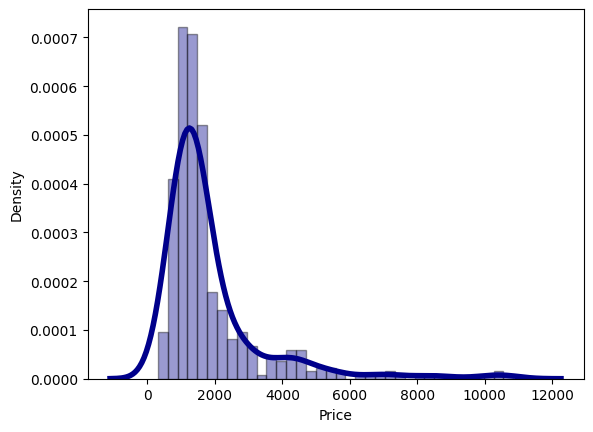

In [186]:
sns.distplot(DATA['Price'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<ipython-input-189-f9d9a019782f>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='GPR', ylabel='Density'>

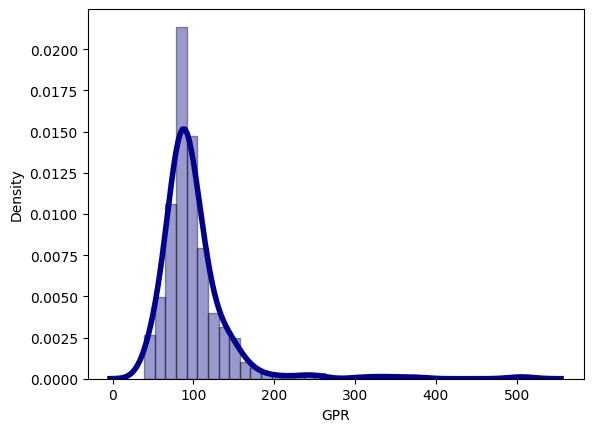

In [189]:
sns.distplot(DATA['GPR'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [193]:
DATA.head(2)

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,974.075000,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08


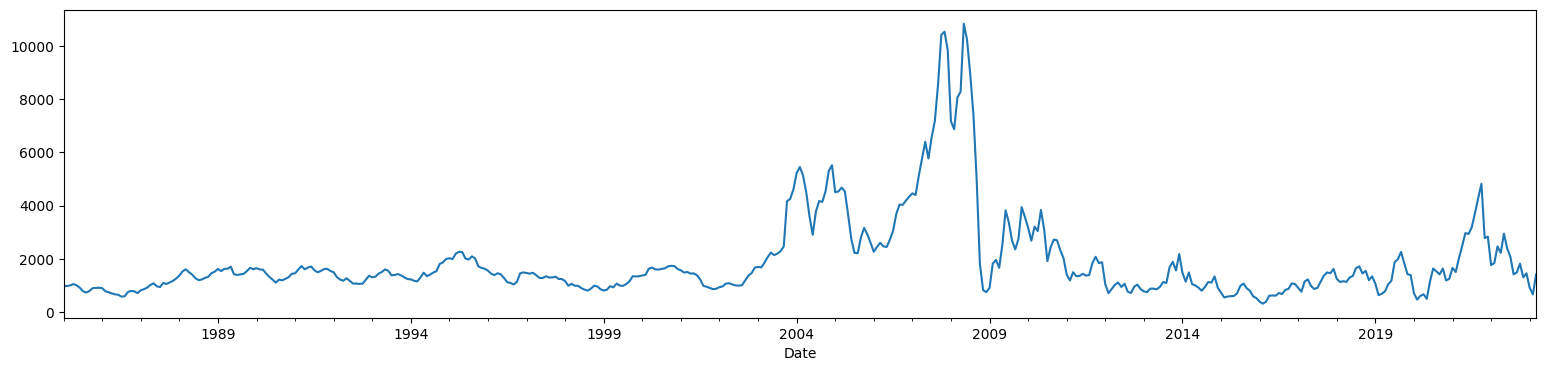

In [191]:
DATA['Price'].plot(figsize=(19, 4))
plt.show()

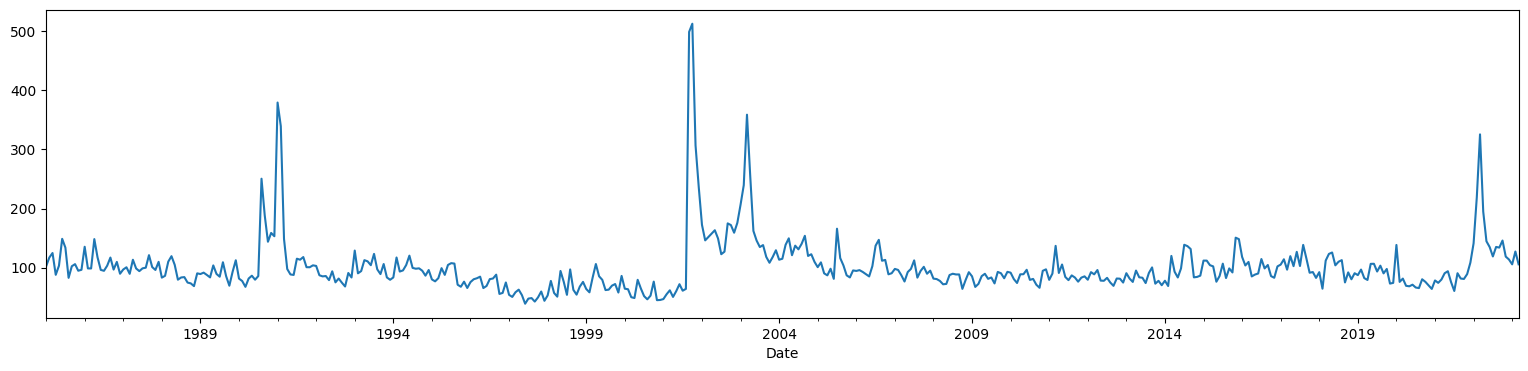

In [192]:
DATA['GPR'].plot(figsize=(19, 4))
plt.show()

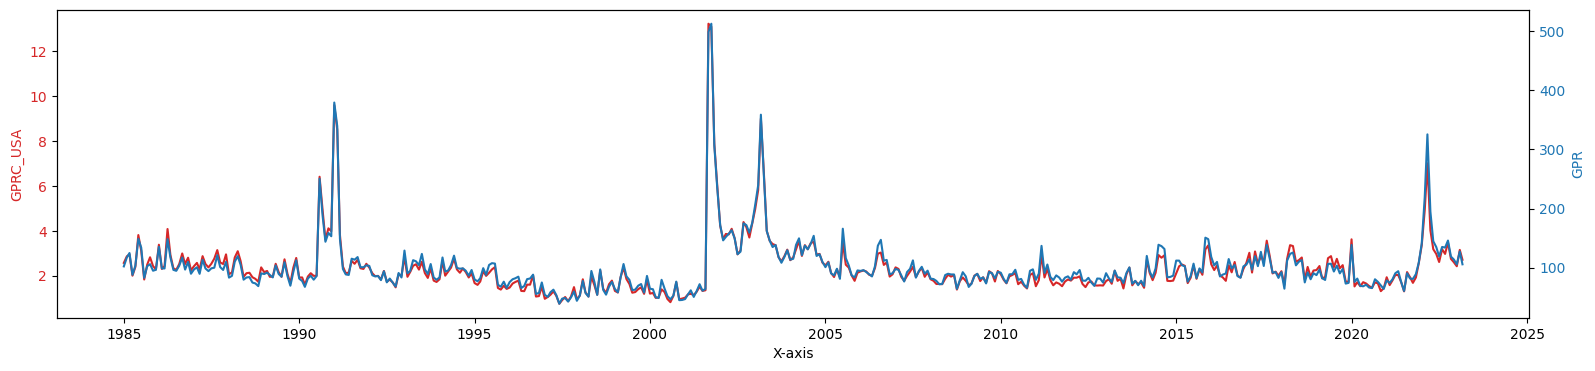

In [196]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(19, 4))

color1 = 'tab:red'
ax1.plot(DATA['GPRC_USA'], color=color1)
ax1.set_ylabel('GPRC_USA', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis (right)
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis (right)
color2 = 'tab:blue'
ax2.plot(DATA['GPR'], color=color2)
ax2.set_ylabel('GPR', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Set x-axis label
ax1.set_xlabel('X-axis')

# Show the plot
plt.show()

#####Second Round Import

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [200]:
#testing for causality with granger's causality test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(DATA, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(DATA[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(DATA, variables = DATA.columns)
#If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

,Price_x,GPR_x,GPRC_ARG_x,GPRC_AUS_x,GPRC_BEL_x,GPRC_BRA_x,GPRC_CAN_x,GPRC_CHE_x,GPRC_CHL_x,GPRC_CHN_x,...,GPRC_SAU_x,GPRC_SWE_x,GPRC_THA_x,GPRC_TUN_x,GPRC_TUR_x,GPRC_TWN_x,GPRC_UKR_x,GPRC_USA_x,GPRC_VEN_x,GPRC_ZAF_x
Price_y,1.0000,0.4235,0.7301,0.3536,0.2846,0.0914,0.5492,0.1149,0.3339,0.1732,...,0.7287,0.2218,0.2864,0.7831,0.2224,0.0242,0.1541,0.3968,0.0130,0.5624
GPR_y,0.5964,1.0000,0.7344,0.2284,0.0649,0.1770,0.0361,0.2667,0.0331,0.0250,...,0.0016,0.1940,0.5009,0.5728,0.0935,0.0309,0.5508,0.1141,0.1398,0.5489
GPRC_ARG_y,0.0959,0.0047,1.0000,0.2410,0.0240,0.1184,0.0000,0.0358,0.1341,0.4768,...,0.0167,0.1006,0.5257,0.8042,0.0041,0.4232,0.0555,0.0026,0.0215,0.0050
GPRC_AUS_y,0.6255,0.0000,0.0086,1.0000,0.0000,0.0002,0.0004,0.0551,0.0424,0.0000,...,0.5696,0.0045,0.0066,0.0935,0.0250,0.0000,0.0000,0.0000,0.0016,0.0630
GPRC_BEL_y,0.1399,0.0402,0.0575,0.0080,1.0000,0.7719,0.0035,0.2388,0.2620,0.0030,...,0.7107,0.0088,0.2322,0.5921,0.0695,0.0000,0.0001,0.0656,0.0727,0.1908
GPRC_BRA_y,0.0397,0.0006,0.0612,0.0279,0.0012,1.0000,0.0014,0.0464,0.0259,0.0033,...,0.0057,0.0012,0.1244,0.7380,0.0297,0.0163,0.0098,0.0003,0.0005,0.8374
GPRC_CAN_y,0.2609,0.1361,0.0300,0.3012,0.2042,0.4335,1.0000,0.0418,0.0052,0.3311,...,0.1369,0.4215,0.7411,0.5175,0.1143,0.0821,0.6200,0.1218,0.1540,0.3412
GPRC_CHE_y,0.2333,0.0000,0.0083,0.0000,0.0167,0.0216,0.0000,1.0000,0.0049,0.8940,...,0.0456,0.0611,0.1704,0.0094,0.8718,0.0538,0.0809,0.0000,0.1757,0.0245
GPRC_CHL_y,0.4445,0.0027,0.0042,0.0001,0.2016,0.0876,0.0001,0.0012,1.0000,0.1784,...,0.1181,0.0537,0.1573,0.0142,0.0956,0.4928,0.3163,0.0008,0.0024,0.0000
GPRC_CHN_y,0.0331,0.0470,0.0224,0.0201,0.0015,0.2826,0.0045,0.2182,0.0167,1.0000,...,0.3334,0.0757,0.0176,0.2144,0.1482,0.0067,0.0080,0.0471,0.0051,0.0010


USDINRCLOSE and CrudeOil show the causation factor but not gold. still being considered.

In [ ]:
#cointegration test to find statistical relation amongst variables.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(EconomyData, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(EconomyData,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(EconomyData.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(EconomyData)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
USDINRClose ::  15.09     > 24.2761   =>   False
CrudeOil ::  6.53      > 12.3212   =>   False
Gold   ::  1.0       > 4.1296    =>   False


If there is cointegration:
1.    Implies that the series in question are related and therefore can be combined in a linear fashion.
2.  That is, even if there are shocks in the short run, which may affect movement in the individual series, they would converge with time (in the long run).
3.    Estimate both long-run and short-run models.
4. The estimation will require the use of vector autoregressive (VAR) model and vector error correction model (VECM) analysis.

If there is no cointegration:
1.    Estimate only the short-run model, which is VAR and not VECM.
source : http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html

In [ ]:
nobs = 4
EconomyData_train, EconomyData_test = EconomyData[0:-nobs], EconomyData[-nobs:]

# Check size
print(EconomyData_train.shape)  # (154, 3)
print(EconomyData_test.shape)  # (4, 3)

(154, 3)
(4, 3)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in EconomyData_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "USDINRClose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4539
 No. Lags Chosen       = 0
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.9007. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CrudeOil" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6594
 No. Lags Chosen       = 9
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.4521. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data 

In [ ]:
#series needs to be stationary hence differencing it.
#1st difference
EconomyData_train = EconomyData_train.diff().dropna()


In [ ]:
# ADF Test on each column
for name, column in EconomyData_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "USDINRClose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0304
 No. Lags Chosen       = 0
 Critical value 1%     = -3.474
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CrudeOil" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.106
 No. Lags Chosen       = 8
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0009. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

Now after 1st order of differencing as per the ADF test where p value < 0.05 it can be said the series is stationary

In [ ]:
model = VAR(EconomyData_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Program Files (x86)\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  7.585526367576263
BIC :  7.824253777116759
FPE :  1969.554848934887
HQIC:  7.68250573292433 

Lag Order = 2
AIC :  7.558264740494836
BIC :  7.977886439654528
FPE :  1916.8993648149367
HQIC:  7.728736877646785 

Lag Order = 3
AIC :  7.5677119123714025
BIC :  8.169838971190654
FPE :  1935.8583333662293
HQIC:  7.812336997278004 

Lag Order = 4
AIC :  7.596681191997047
BIC :  8.382949017043174
FPE :  1994.2346220164366
HQIC:  7.9161288111983135 

Lag Order = 5
AIC :  7.60541065998318
BIC :  8.577479505528299
FPE :  2014.1559979330214
HQIC:  8.000359986491791 

Lag Order = 6
AIC :  7.685673920195267
BIC :  8.84522941302784
FPE :  2186.453905942315
HQIC:  8.156813893179809 

Lag Order = 7
AIC :  7.760492179645749
BIC :  9.109245857952256
FPE :  2362.3917353224942
HQIC:  8.308521687992851 

Lag Order = 8
AIC :  7.817028027391899
BIC :  9.35671789416116
FPE :  2508.56298333459
HQIC:  8.442656097226902 

Lag Order = 9
AIC :  7.878965593128216
BIC :  9.61135668454755
FPE :  

In [ ]:
x = model.select_order(maxlags=12)
x.summary()


,AIC,BIC,FPE,HQIC
0,7.737,7.800*,2291.,7.762*
1,7.720,7.971,2252.,7.822
2,7.682*,8.121,2170.*,7.861
3,7.684,8.311,2174.,7.939
4,7.692,8.507,2194.,8.023
5,7.694,8.698,2202.,8.102
6,7.788,8.980,2422.,8.272
7,7.851,9.232,2589.,8.412
8,7.898,9.467,2724.,8.536
9,7.931,9.688,2827.,8.645


In [ ]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 16, Jun, 2020
Time:                     11:00:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.97789
Nobs:                     151.000    HQIC:                   7.72874
Log likelihood:          -1192.43    FPE:                    1916.90
AIC:                      7.55826    Det(Omega_mle):         1673.24
--------------------------------------------------------------------
Results for equation USDINRClose
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.083402         0.047675            1.749           0.080
L1.USDINRClose         0.016028         0.082904            0.193           0.847
L1.CrudeOil            0.024353         0.016700  

In [ ]:
#to check if any serial pattern is still left in the residuals durbin watson statistical test can be performed.
#The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
#then there is no significant serial correlation.
#The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(EconomyData_train.columns, out):
    print(col, ':', round(val, 2))

USDINRClose : 1.96
CrudeOil : 2.02
Gold : 1.92


As the values are closer to 2 no significant correlation.

In [ ]:
#forecasting
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = EconomyData_train.values[-lag_order:]
forecast_input

2


array([[ 0.319496,  6.049999,  2.199952],
       [ 0.154503,  5.61    , 59.300048]])

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=EconomyData.index[-nobs:], columns=EconomyData.columns + '_2d')
df_forecast

,USDINRClose_2d,CrudeOil_2d,Gold_2d
Date,,,
2020-05-25,0.159604,0.982907,-4.079060
2020-06-01,0.090039,-1.722465,6.828139
2020-06-08,0.056952,-0.285623,3.875078
2020-06-15,0.050888,-0.237223,2.864957


In [ ]:
#inverting the values from differencing
def invert_transformation(EconomyData_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = EconomyData_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_2d'] = (EconomyData_train[col].iloc[-1]-EconomyData_train[col].iloc[-2]) + EconomyData_train[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = EconomyData_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(EconomyData_train, df_forecast)        
df_results.loc[:, ['USDINRClose_forecast', 'CrudeOil_forecast', 'Gold_forecast']]

,USDINRClose_forecast,CrudeOil_forecast,Gold_forecast
Date,,,
2020-05-25,0.314107,6.592907,55.220988
2020-06-01,0.404146,4.870442,62.049128
2020-06-08,0.461098,4.584819,65.924206
2020-06-15,0.511986,4.347596,68.789162


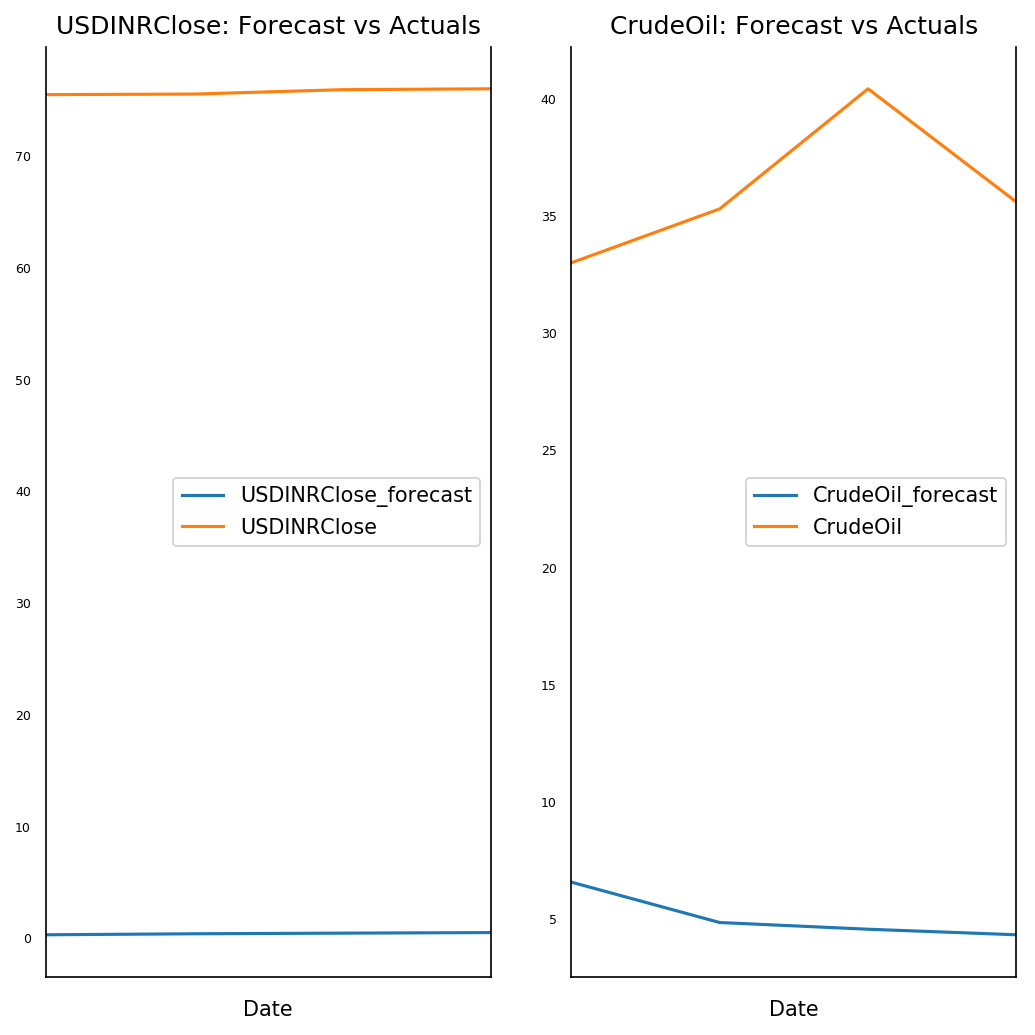

In [ ]:
fig, axes = plt.subplots(nrows=int(len(EconomyData.columns)/2), ncols=2, dpi=150, figsize=(7,7))
for i, (col,ax) in enumerate(zip(EconomyData.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    EconomyData_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'rmse':rmse})

print('Forecast Accuracy of: USDINRClose')
accuracy_prod = forecast_accuracy(df_results['USDINRClose_forecast'].values, EconomyData_test['USDINRClose'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: CrudeOil')
accuracy_prod = forecast_accuracy(df_results['CrudeOil_forecast'].values, EconomyData_test['CrudeOil'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Gold')
accuracy_prod = forecast_accuracy(df_results['Gold_forecast'].values, EconomyData_test['Gold'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))


Forecast Accuracy of: USDINRClose
rmse :  75.3445

Forecast Accuracy of: CrudeOil
rmse :  31.159

Forecast Accuracy of: Gold
rmse :  1664.7136


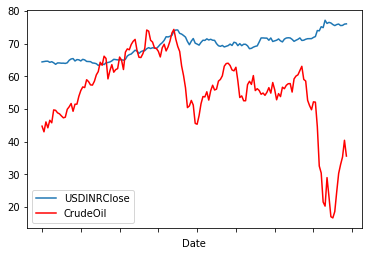

In [ ]:
ax = plt.gca()

EconomyData1.plot(kind='line',x='Date',y='USDINRClose',ax=ax)
EconomyData1.plot(kind='line',x='Date',y='CrudeOil', color='red', ax=ax)
#EconomyData1.plot(kind='line',x='Date',y='Gold', color='yellow', ax=ax)

plt.show()

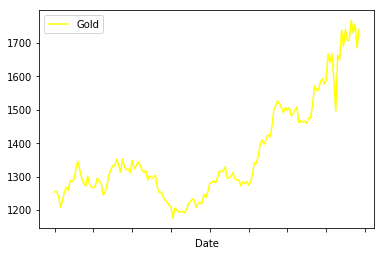

In [ ]:
ax = plt.gca()

EconomyData1.plot(kind='line',x='Date',y='Gold',ax=ax,color="yellow")
plt.show()